In [1]:
import tensorflow as tf
import os
import pickle
import numpy as np

In [2]:
CIFAR_DIR = '/home/commaai-03/Data/dataset/cifar-10-python'

def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

In [3]:
filenames = [os.path.join(CIFAR_DIR, file) 
             for file in os.listdir(CIFAR_DIR)
             if '.html' not in file]
filenames.sort()
meta_file = filenames[0]
train_files = filenames[1:-1]
test_file = [filenames[-1]]

In [4]:
_test_data = unpickle(test_file[0])
for k, v in _test_data.items():
    print(k)

b'batch_label'
b'labels'
b'data'
b'filenames'


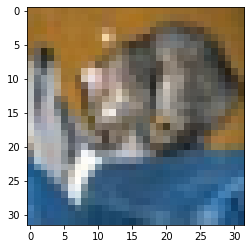

In [5]:
img_arr = _test_data[b'data'][0]
# 32 * 32 * 3 (R,G,B)
img_arr_reshaped = img_arr.reshape((3, 32, 32))
img = img_arr_reshaped.transpose(1, 2, 0)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
imshow(img)

In [6]:
class CifarData:
    
    def __init__(self, filenames, need_shuffle):
        all_data = []
        all_labels = []
        for filename in filenames:
            data, labels = self.load_data(filename)
            all_data.append(data)
            all_labels.append(labels)
        self._data = np.vstack(all_data)
        self._data = self._data / 127.5 - 1
        self._labels = np.hstack(all_labels)
        print('[CIFAR-10]: Data shape-> %s' % str(self._data.shape))
        print('[CIFAR-10]: Label shape-> %s' % str(self._labels.shape))
        
        self.num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
            
    def load_data(self, filename):
        import pickle
        with open(filename, mode='rb') as f:
            data = pickle.load(f, encoding='bytes')
        return data[b'data'], data[b'labels']
    
    def _shuffle_data(self):
        index = np.random.permutation(self.num_examples)
        self._data = self._data[index]
        self._labels = self._labels[index]
        
    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self.num_examples:
            rest_num_examples = self.num_examples - self._indicator
            data_rest_part = self._data[self._indicator: self.num_examples]
            label_rest_part = self._labels[self._indicator: self.num_examples]
            
            if self._need_shuffle:
                self._shuffle_data()
            # For new loop, self._indicator + batch_size = self.num_examples
            self._indicator = batch_size - rest_num_examples
            end_indicator = self._indicator
            data_new_part = self._data[:end_indicator]
            label_new_part = self._labels[:end_indicator]
            batch_data = np.concatenate((data_rest_part, data_new_part), axis=0)
            batch_label = np.concatenate((label_rest_part, label_new_part), axis=0)
        else:
            batch_data = self._data[self._indicator:end_indicator]
            batch_label = self._labels[self._indicator:end_indicator]
            self._indicator = end_indicator
        
        return batch_data, batch_label

In [7]:
train_data = CifarData(train_files, need_shuffle=True)
test_data = CifarData(test_file, need_shuffle=False)

[CIFAR-10]: Data shape-> (50000, 3072)
[CIFAR-10]: Label shape-> (50000,)
[CIFAR-10]: Data shape-> (10000, 3072)
[CIFAR-10]: Label shape-> (10000,)


**Model**

In [8]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 3072])
y = tf.placeholder(dtype=tf.int64, shape=[None])

# Dense Layer
hidden1 = tf.keras.layers.Dense(
    units=100, activation=tf.nn.relu)(x)
hidden2 = tf.keras.layers.Dense(
    units=100, activation=tf.nn.relu)(hidden1)
hidden3= tf.keras.layers.Dense(
    units=50, activation=tf.nn.relu)(hidden2)
y_ = tf.keras.layers.Dense(units=10)(hidden3)

# tf.nn.softmax_cross_entropy_with_logits_v2: (labels: one-hot), shape=[batch_size, num_classes]
# tf.losses.sparse_softmax_cross_entropy: (labels: int), shape=[batch_size]

# tf.losses.sparse_softmax_cross_entropy ->
# tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits)

_loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)
# y_ -> softmax, y-> one-hot, loss = y * log(y_)

# indices
predict = tf.argmax(y_, 1)
correct_pred = tf.equal(predict, y)
accuracy = tf.math.reduce_mean(tf.cast(correct_pred, tf.float64))

with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(_loss)

W0917 15:30:21.884691 140135234676544 deprecation.py:506] From /home/commaai-03/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0917 15:30:21.932950 140135234676544 deprecation.py:323] From /home/commaai-03/.local/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
batch_size = 32
train_steps = 10000
test_steps = 100

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(train_steps):
        batch_data, batch_labels = train_data.next_batch(batch_size)
        loss, acc, _ = sess.run([_loss, accuracy, train_op], 
                                feed_dict={x: batch_data, y: batch_labels})
        if (i+1) % 500 == 0:
            print('[Train] Step: %d, loss: %4.5f, acc: %4.5f'
                  % (i+1, loss, acc))
        if (i+1) % 5000 == 0:
            all_test_acc = []
            for j in range(test_steps):
                test_batch, test_labels = test_data.next_batch(batch_size)
                test_acc = sess.run([accuracy], feed_dict={x: test_batch, 
                                                           y: test_labels})
                all_test_acc.append(test_acc)
            test_acc = np.mean(all_test_acc)
            print('[Test] Step: %d, acc: %4.5f' % (i+1, test_acc))

1.5164541 <class 'numpy.float64'>
[Train] Step: 500, loss: 1.51645, acc: 0.43750
1.7065395 <class 'numpy.float64'>
[Train] Step: 1000, loss: 1.70654, acc: 0.40625
1.3629048 <class 'numpy.float64'>
[Train] Step: 1500, loss: 1.36290, acc: 0.40625
1.4554199 <class 'numpy.float64'>
[Train] Step: 2000, loss: 1.45542, acc: 0.46875
1.459666 <class 'numpy.float64'>
[Train] Step: 2500, loss: 1.45967, acc: 0.50000
1.483187 <class 'numpy.float64'>
[Train] Step: 3000, loss: 1.48319, acc: 0.46875
1.4225476 <class 'numpy.float64'>
[Train] Step: 3500, loss: 1.42255, acc: 0.46875
1.0500748 <class 'numpy.float64'>
[Train] Step: 4000, loss: 1.05007, acc: 0.59375
1.780751 <class 'numpy.float64'>
[Train] Step: 4500, loss: 1.78075, acc: 0.34375
1.2772917 <class 'numpy.float64'>
[Train] Step: 5000, loss: 1.27729, acc: 0.53125
[Test] Step: 5000, acc: 0.48125
1.5199296 <class 'numpy.float64'>
[Train] Step: 5500, loss: 1.51993, acc: 0.31250
1.6363537 <class 'numpy.float64'>
[Train] Step: 6000, loss: 1.63635, a